In [41]:
# libraries
import csv
import numpy as np
import pandas as pd
from random import shuffle
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import train_test_split
from interpret import show 

In [42]:
# destination: No Urgent Place, Home, Work
# passanger: Alone, Friend(s), Kid(s), Partner (who are the passengers in the car)
# weather: Sunny, Rainy, Snowy
# temperature:55, 80, 30
# time: 2PM, 10AM, 6PM, 7AM, 10PM
# coupon: Restaurant(<$20), Coffee House, Carry out & Take away, Bar, Restaurant($20-$50)
# expiration: 1d, 2h (the coupon expires in 1 day or in 2 hours)
# gender: Female, Male
# age: 21, 46, 26, 31, 41, 50plus, 36, below21
# maritalStatus: Unmarried partner, Single, Married partner, Divorced, Widowed
# has_Children:1, 0
# education: Some college - no degree, Bachelors degree, Associates degree, High School Graduate, Graduate degree (Masters or Doctorate), Some High School
# occupation: Unemployed, Architecture & Engineering, Student,
# Education&Training&Library, Healthcare Support,
# Healthcare Practitioners & Technical, Sales & Related, Management,
# Arts Design Entertainment Sports & Media, Computer & Mathematical,
# Life Physical Social Science, Personal Care & Service,
# Community & Social Services, Office & Administrative Support,
# Construction & Extraction, Legal, Retired,
# Installation Maintenance & Repair, Transportation & Material Moving,
# Business & Financial, Protective Service,
# Food Preparation & Serving Related, Production Occupations,
# Building & Grounds Cleaning & Maintenance, Farming Fishing & Forestry
# income: $37500 - $49999, $62500 - $74999, $12500 - $24999, $75000 - $87499,
# $50000 - $62499, $25000 - $37499, $100000 or More, $87500 - $99999, Less than $12500
# Bar: never, less1, 1~3, gt8, nan4~8 (feature meaning: how many times do you go to a bar every month?)
# CoffeeHouse: never, less1, 4~8, 1~3, gt8, nan (feature meaning: how many times do you go to a coffeehouse every month?)
# CarryAway:n4~8, 1~3, gt8, less1, never (feature meaning: how many times do you get take-away food every month?)
# RestaurantLessThan20: 4~8, 1~3, less1, gt8, never (feature meaning: how many times do you go to a restaurant with an average expense per person of less than $20 every month?)
# Restaurant20To50: 1~3, less1, never, gt8, 4~8, nan (feature meaning: how many times do you go to a restaurant with average expense per person of $20 - $50 every month?)
# toCoupon_GEQ15min:0,1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 15 minutes)
# toCoupon_GEQ25min:0, 1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 25 minutes)
# direction_same:0, 1 (feature meaning: whether the restaurant/bar is in the same direction as your current destination)
# direction_opp:1, 0 (feature meaning: whether the restaurant/bar is in the same direction as your current destination)
# Y:1, 0 (whether the coupon is accepted)

In [43]:
df = pd.read_csv('coupon-recommendation.csv',sep = ',')

cols = ['destination', 'passenger', 'weather', 'temperature', 'time', 'coupon', 'expiration', 'gender', 'age', 
        'maritalStatus', 'has_children', 'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
        'CarryAway', 'RestaurantLessThan20', ' Restaurant20To50', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 
        'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y']

df.columns = cols


df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passenger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


In [44]:
#destination = pd.get_dummies(df['destination'], prefix='destination')
#passenger = pd.get_dummies(df['passenger'], prefix='passenger')
#weather = pd.get_dummies(df['weather'], prefix='weather')
#time = pd.get_dummies(df['time'], prefix='time')
#coupon = pd.get_dummies(df['coupon'], prefix='coupon')
#expiration = pd.get_dummies(df['expiration'], prefix='expiration')
#gender = pd.get_dummies(df['gender'], prefix='gender')
#age = pd.get_dummies(df['age'], prefix='age')
#maritalStatus = pd.get_dummies(df['maritalStatus'], prefix='maritalStatus')
#education = pd.get_dummies(df['education'], prefix='education')
#occupation = pd.get_dummies(df['occupation'], prefix='occupation')
#income = pd.get_dummies(df['income'], prefix='income')
#car = pd.get_dummies(df['car'], prefix='car')
#Bar = pd.get_dummies(df['Bar'], prefix='Bar')
#CoffeeHouse = pd.get_dummies(df['CoffeeHouse'], prefix='CoffeeHouse')
#CarryAway = pd.get_dummies(df['CarryAway'], prefix='CarryAway')
#RestaurantLessThan20 = pd.get_dummies(df['RestaurantLessThan20'], prefix='RestaurantLessThan20')
#Restaurant20To50 = pd.get_dummies(df[' Restaurant20To50'], prefix=' Restaurant20To50')



#new_df = df.join([destination, passenger, weather, time, coupon, expiration, gender, age, maritalStatus, education,
#                  occupation, income, car, Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50])
#drop_cols = ['destination', 'passenger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 
#            'maritalStatus', 'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
#            'CarryAway', 'RestaurantLessThan20', ' Restaurant20To50']
#new_df = new_df.drop(columns=drop_cols, axis=1)
#new_df.columns

#pd.set_option('display.max_columns', None)


#new_df.info()
#new_df.head(30)

In [45]:
# Break dataset into train and test data

acceptance_index = list(new_df.columns).index("Y")
train_cols = list(new_df.columns[0:acceptance_index]) + list(new_df.columns[acceptance_index+1:])
label = new_df.columns[acceptance_index]
X_df = new_df[list(train_cols)]
y_df = new_df[label]

In [46]:
# y_df = y_df.apply(lambda x: "low" if x < 7.0 else ("med" if x <=15.0 else "high"))
# y_df = y_df.apply(lambda x: "low" if x <= 10 else "high")

In [ ]:
dataset = {
        'X': X_df,
        'y': y_df,
}

# create a train/test split
seed = 1
X_train, X_test, y_train, y_test = train_test_split(dataset['X'],dataset['y'], test_size=0.25, random_state=seed)

## SVM

In [53]:
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [54]:
#Training accuracy
train_pred = clf.predict(X_train).tolist()
same_train = sum(x == y for x, y in zip(train_pred, y_train.tolist()))
accuracy_train = round(same_train/ len(train_pred), 5)

#Test set accuracy
predictions = clf.predict(X_test).tolist()
same_test = sum(x == y for x, y in zip(predictions, y_test.tolist()))
accuracy_test = round(same_test / len(predictions), 5)

print("The accuracy of the model on the training set is: ", accuracy_train)
print("The accuracy of the model on the test set is: ", accuracy_test)

The accuracy of the model on the training set is:  0.6961
The accuracy of the model on the test set is:  0.69473


<AxesSubplot:>

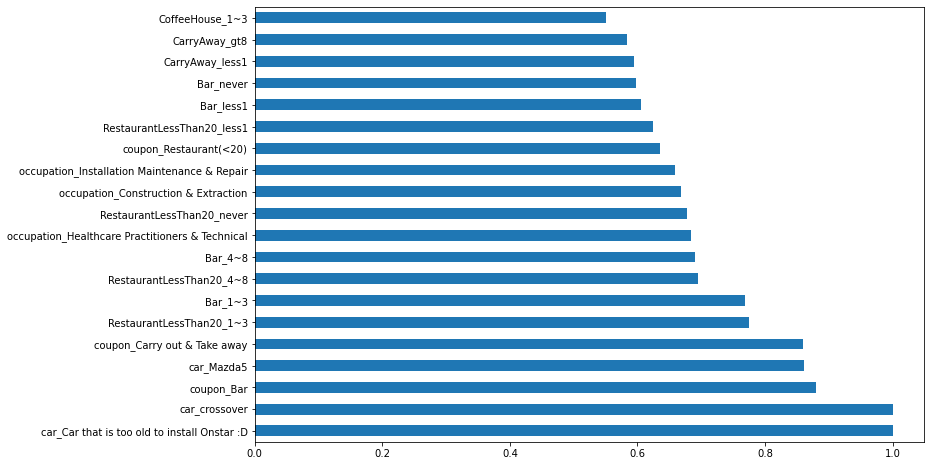

In [55]:
plt.figure(figsize=(12,8))
# Top 10 most important features
pd.Series(abs(clf.coef_[0]), index=dataset['X'].columns).nlargest(20).plot(kind='barh')

## Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0,max_iter=10000).fit(X_train, y_train)

In [61]:
#Training accuracy
train_pred = lr.predict(X_train).tolist()
same_train = sum(x == y for x, y in zip(train_pred, y_train.tolist()))
accuracy_train = round(same_train/ len(train_pred), 5)

#Test set accuracy
predictions = lr.predict(X_test).tolist()
same_test = sum(x == y for x, y in zip(predictions, y_test.tolist()))
accuracy_test = round(same_test / len(predictions), 5)

print("The accuracy of the model on the training set is: ", accuracy_train)
print("The accuracy of the model on the test set is: ", accuracy_test)

The accuracy of the model on the training set is:  0.69295
The accuracy of the model on the test set is:  0.68969


<AxesSubplot:>

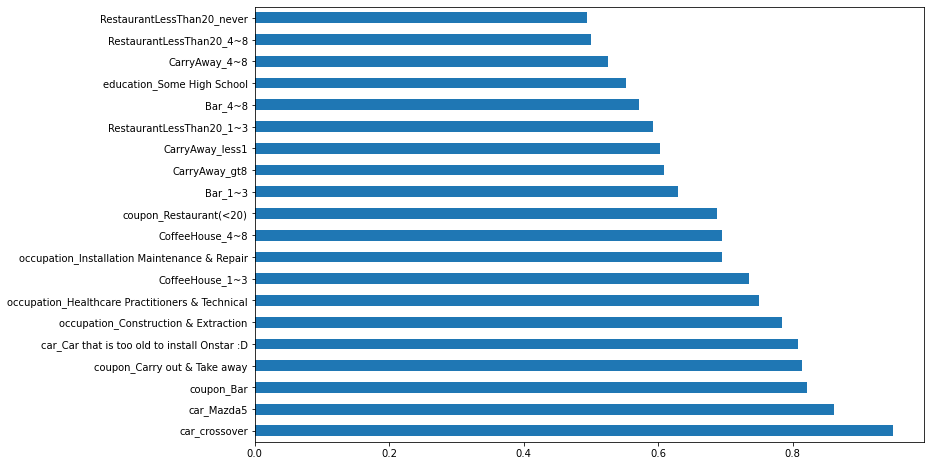

In [62]:
plt.figure(figsize=(12,8))
# Top 10 most important features
pd.Series(abs(lr.coef_[0]), index=dataset['X'].columns).nlargest(20).plot(kind='barh')

## Decision Tree

In [63]:
from sklearn import tree
dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

In [64]:
#Training accuracy
train_pred = dtree.predict(X_train).tolist()
same_train = sum(x == y for x, y in zip(train_pred, y_train.tolist()))
accuracy_train = round(same_train/ len(train_pred), 5)

#Test set accuracy
predictions = dtree.predict(X_test).tolist()
same_test = sum(x == y for x, y in zip(predictions, y_test.tolist()))
accuracy_test = round(same_test / len(predictions), 5)

print("The accuracy of the model on the training set is: ", accuracy_train)
print("The accuracy of the model on the test set is: ", accuracy_test)

The accuracy of the model on the training set is:  0.99842
The accuracy of the model on the test set is:  0.69095


<AxesSubplot:>

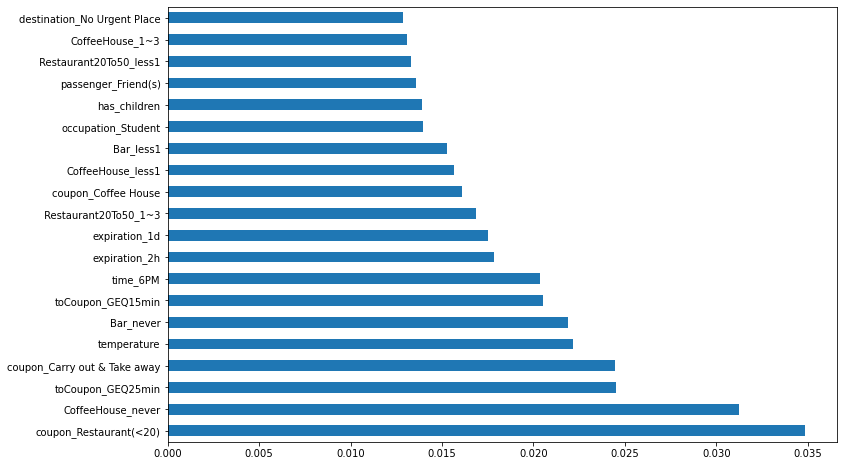

In [60]:
plt.figure(figsize=(12,8))
# Top 10 most important features
pd.Series(abs(dtree.feature_importances_), index=dataset['X'].columns).nlargest(20).plot(kind='barh')

## GAMs

In [69]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import train_test_split


# create a train/test split
seed = 1
X_train, X_test, y_train, y_test = train_test_split(dataset['X'],dataset['y'], test_size=0.25, random_state=seed)

# train a GAM for the training dataset
ebm = ExplainableBoostingClassifier()

ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['temperature', 'has_children',
                                             'toCoupon_GEQ5min',
                                             'toCoupon_GEQ15min',
                                             'toCoupon_GEQ25min',
                                             'direction_same', 'direction_opp',
                                             'destination_Home',
                                             'destination_No Urgent Place',
                                             'destination_Work',
                                             'passenger_Alone',
                                             'passenger_Friend(s)',
                                             'passenger_Kid(s)',
                                             'passenger_Partner',
                                             'weather_Rainy', 'weather_Snowy',
                                             'weathe...
                                           

In [70]:
#training set
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7598/1651107307680/ -->

In [73]:
incorrect_indices = [index for index, value in enumerate(zip(predictions, y_test.tolist())) if value[0] != value[1]]

In [74]:
test_indices = incorrect_indices[:20]

ebm_local = ebm.explain_local(X_test.iloc[test_indices, :], y_test.iloc[test_indices], name='EBM')
show(ebm_local)

<!-- http://127.0.0.1:7598/1651079150656/ -->